<a href="https://colab.research.google.com/github/thantzintun232/AI-for-Indoor-Air-Quality-Forecasting/blob/main/NTLL__KF_Hybrid_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
full_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dissertation/cleaned_air_quality.csv')
full_df.head()

,installation_name,installation_site,timestamp,pm2_5,temp_aq,humidity_aq,voc_aq,co2_gas,source_file,date,weekday,is_weekend
0,External - front of James Graham,Headingley Campus,2025-03-01 00:04:58,24.09,3.039062,76.490273,231.0,688.0,2025-03-01.xlsx,2025-03-01,Saturday,True
1,External - front of James Graham,Headingley Campus,2025-03-01 00:09:58,24.19,2.796875,76.534142,236.0,713.0,2025-03-01.xlsx,2025-03-01,Saturday,True
2,External - front of James Graham,Headingley Campus,2025-03-01 00:14:58,27.03,2.507812,77.245590,244.0,723.0,2025-03-01.xlsx,2025-03-01,Saturday,True
3,External - front of James Graham,Headingley Campus,2025-03-01 00:19:58,24.36,2.273438,80.606392,228.0,633.0,2025-03-01.xlsx,2025-03-01,Saturday,True
4,External - front of James Graham,Headingley Campus,2025-03-01 00:24:58,25.00,2.281250,79.978867,223.0,660.0,2025-03-01.xlsx,2025-03-01,Saturday,True


In [ ]:
pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.4/249.4 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 19.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter

df_co2 = full_df[['timestamp', 'co2_gas']].copy()
y = df_co2['co2_gas'].astype(float).to_numpy()

split_idx = int(len(y) * 0.8)
y_train, y_test = y[:split_idx], y[split_idx:]

kf = KalmanFilter(
    transition_matrices=1.0,
    observation_matrices=1.0,
    initial_state_mean=y_train[0]
)

kf = kf.em(y_train, n_iter=15)

x_train, _ = kf.smooth(y_train)
x_test,  _ = kf.filter(y_test)

co2_kf = np.concatenate([x_train.ravel(), x_test.ravel()])
df_co2['co2_gas_kf'] = co2_kf

print(df_co2[['timestamp', 'co2_gas', 'co2_gas_kf']].head())
print(df_co2[['timestamp', 'co2_gas', 'co2_gas_kf']].tail())


             timestamp  co2_gas  co2_gas_kf
0  2025-03-01 00:04:58    688.0  692.286319
1  2025-03-01 00:09:58    713.0  694.504133
2  2025-03-01 00:14:58    723.0  691.429438
3  2025-03-01 00:19:58    633.0  679.320966
4  2025-03-01 00:24:58    660.0  680.467034
                 timestamp  co2_gas  co2_gas_kf
74193  2025-03-31 23:39:58    496.0  501.903776
74194  2025-03-31 23:44:58    531.0  513.852310
74195  2025-03-31 23:49:58    495.0  506.110499
74196  2025-03-31 23:54:58    492.0  500.315940
74197  2025-03-31 23:59:58    502.0  501.007509


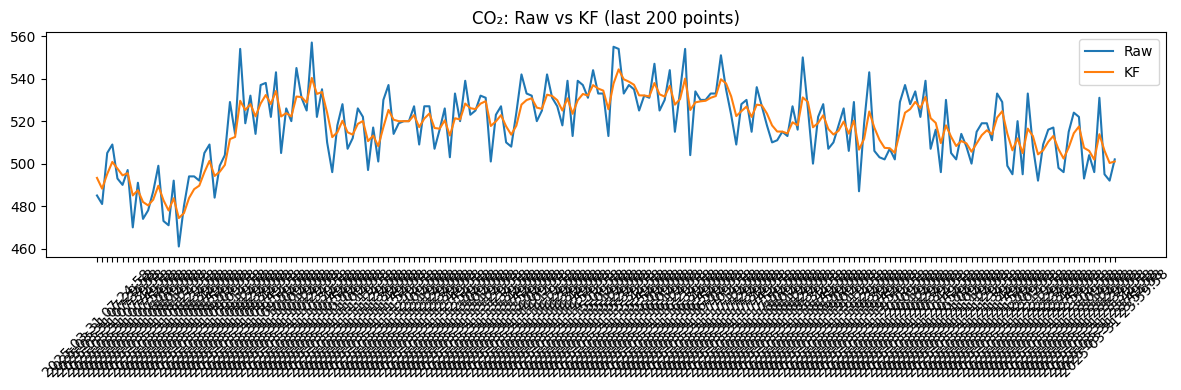

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(df_co2['timestamp'].iloc[-200:], df_co2['co2_gas'].iloc[-200:], label='Raw')
plt.plot(df_co2['timestamp'].iloc[-200:], df_co2['co2_gas_kf'].iloc[-200:], label='KF')
plt.legend(); plt.title('CO₂: Raw vs KF (last 200 points)'); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

source_col = 'co2_gas_kf'

co2_values = df_co2[[source_col]].values

split_index = int(len(co2_values) * 0.8)
train_data = co2_values[:split_index]
test_data  = co2_values[split_index:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled  = scaler.transform(test_data)

scaled = np.vstack([train_scaled, test_scaled])

def create_sequences(data, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(scaled, window_size)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train_lstm = X_train.reshape((X_train.shape[0], window_size, 1))
X_test_lstm  = X_test.reshape((X_test.shape[0], window_size, 1))

X_train_knn = X_train.reshape((X_train.shape[0], window_size))
X_test_knn  = X_test.reshape((X_test.shape[0], window_size))

print("X_train LSTM:", X_train_lstm.shape)
print("X_train KNN :", X_train_knn.shape)
print("y_train     :", y_train.shape)


X_train LSTM: (59350, 10, 1)
X_train KNN : (59350, 10)
y_train     : (59350, 1)


# KF+KNN

KF+KNN Results:
MAE: 0.024566182207684462
RMSE: 0.03707371636708345
MAPE: 13.331515709721076
R²: 0.9554221267830822


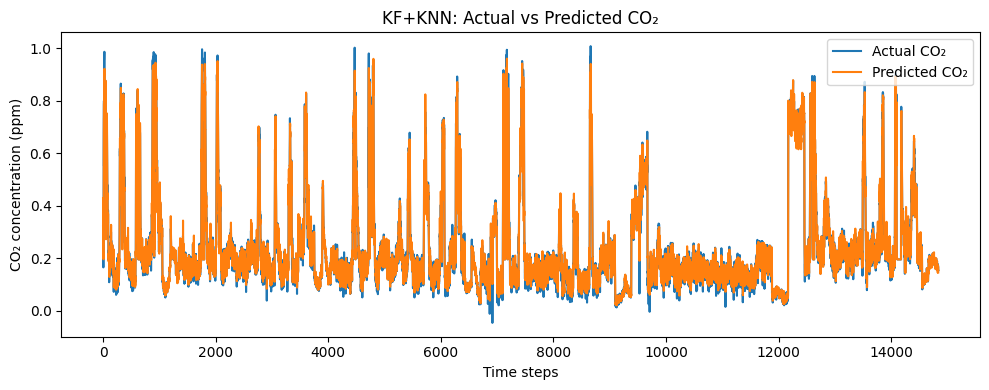

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

knn = KNeighborsRegressor(n_neighbors=5, metric='euclidean')
knn.fit(X_train_knn, y_train)

y_pred_knn = knn.predict(X_test_knn)

mae = mean_absolute_error(y_test, y_pred_knn)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))
mape = np.mean(np.abs((y_test - y_pred_knn) / y_test)) * 100
r2 = r2_score(y_test, y_pred_knn)

print("KF+KNN Results:")
print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R²:", r2)

plt.figure(figsize=(10,4))
plt.plot(y_test, label="Actual CO₂")
plt.plot(y_pred_knn, label="Predicted CO₂")
plt.xlabel("Time steps")
plt.ylabel("CO₂ concentration (ppm)")
plt.title("KF+KNN: Actual vs Predicted CO₂")
plt.legend()
plt.tight_layout()
plt.show()


# KF+LSTM

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 2/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3.7860e-04 - val_loss: 0.0015
Epoch 3/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.7708e-04 - val_loss: 0.0016
Epoch 4/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.6761e-04 - val_loss: 0.0016
Epoch 5/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.6386e-04 - val_loss: 0.0016
Epoch 6/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.7040e-04 - val_loss: 0.0016
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
KF+LSTM Results:
MAE : 0.025636338059000608
RMSE: 0.038675602365186405
MAPE: 14.216214101397002
R²  : 0.9514866492702471


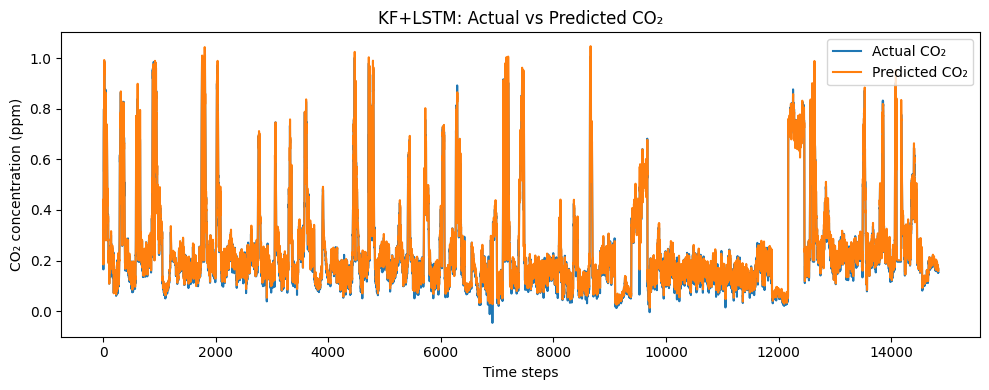

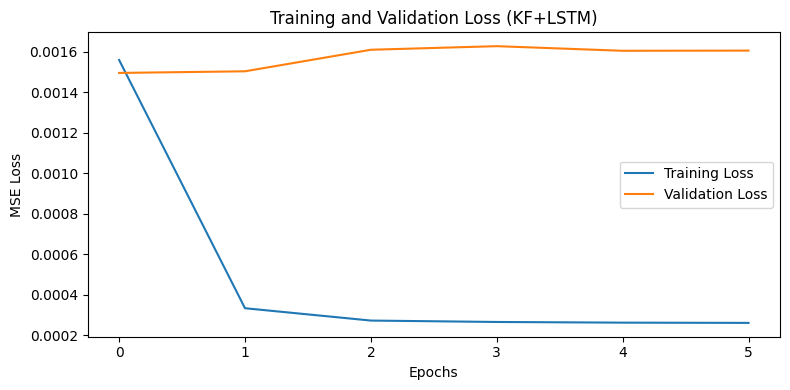

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=50, batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

y_pred_lstm = model.predict(X_test_lstm)

mae = mean_absolute_error(y_test, y_pred_lstm)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))

epsilon = 1e-8
mape = np.mean(np.abs((y_test - y_pred_lstm) / (y_test + epsilon))) * 100

r2 = r2_score(y_test, y_pred_lstm)

print("KF+LSTM Results:")
print("MAE :", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R²  :", r2)

plt.figure(figsize=(10,4))
plt.plot(y_test, label="Actual CO₂")
plt.plot(y_pred_lstm, label="Predicted CO₂")
plt.xlabel("Time steps")
plt.ylabel("CO₂ concentration (ppm)")
plt.title("KF+LSTM: Actual vs Predicted CO₂")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss (KF+LSTM)")
plt.legend()
plt.tight_layout()
plt.show()


# KF+GRU

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1855/1855 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 2/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 2.9012e-04 - val_loss: 0.0016
Epoch 3/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 2.6106e-04 - val_loss: 0.0016
Epoch 4/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 2.6363e-04 - val_loss: 0.0016
Epoch 5/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 2.6684e-04 - val_loss: 0.0016
Epoch 6/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 2.6949e-04 - val_loss: 0.0016
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
KF+GRU Results:
MAE : 0.025512612371473384
RMSE: 0.03811839599389555
MAPE: 13.698474396887983
R²  : 0.9528744606761297


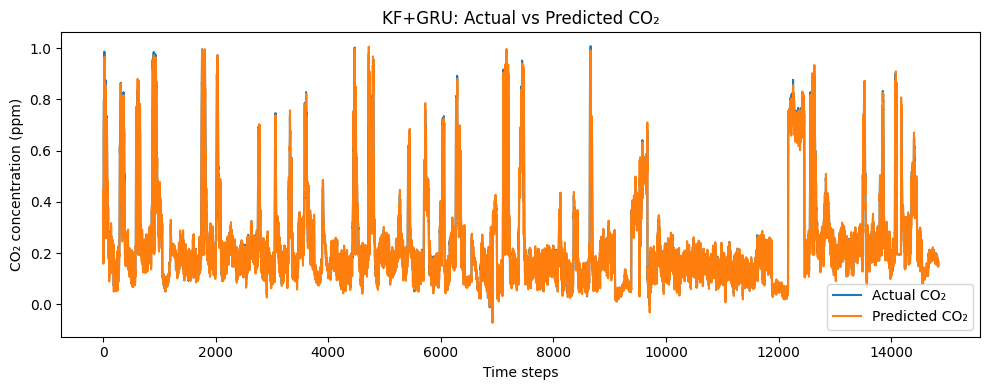

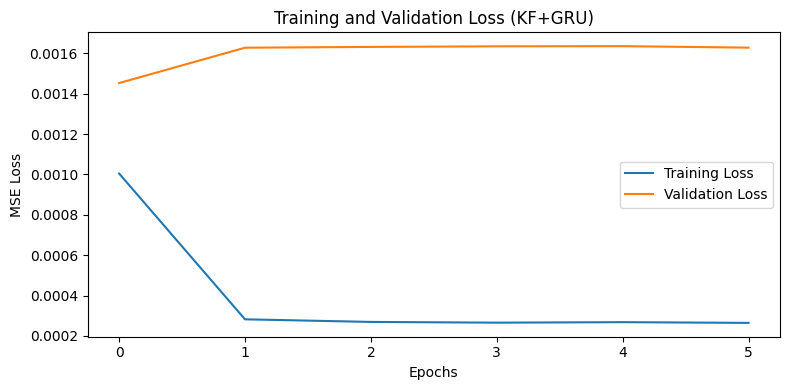

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

gru = Sequential([
    GRU(64, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_gru = gru.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=50, batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

y_pred_gru = gru.predict(X_test_lstm)

mae  = mean_absolute_error(y_test, y_pred_gru)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_gru))

epsilon = 1e-8
mape = np.mean(np.abs((y_test - y_pred_gru) / (y_test + epsilon))) * 100

r2 = r2_score(y_test, y_pred_gru)

print("KF+GRU Results:")
print("MAE :", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R²  :", r2)

plt.figure(figsize=(10,4))
plt.plot(y_test, label="Actual CO₂")
plt.plot(y_pred_gru, label="Predicted CO₂")
plt.xlabel("Time steps")
plt.ylabel("CO₂ concentration (ppm)")
plt.title("KF+GRU: Actual vs Predicted CO₂")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history_gru.history['loss'], label="Training Loss")
plt.plot(history_gru.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss (KF+GRU)")
plt.legend()
plt.tight_layout()
plt.show()
